# Creating records 
## Pipeline 2.0
##### ASTROMER dev team

*July 07 2023*

In [1]:
cd /home

/home


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

from src.data.record import DataPipeline

%load_ext autoreload
%autoreload 2

2023-07-12 14:33:36.139031: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.3) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [9]:
METAPATH = './data/raw_data/alcock/new_metadata.parquet'
OBSPATH  = './data/raw_data/alcock/parquets/'
config_path = './data/raw_data/alcock/config.toml'

In [4]:
metadata = pd.read_parquet(METAPATH)

In [5]:
metadata['Class'] = pd.Categorical(metadata['Class'])
metadata['Label'] = metadata['Class'].cat.codes
metadata['Path'] = metadata['Path'].apply(lambda x: os.path.join(OBSPATH, x)) 

In [6]:
metadata.sample()

,ID,Class,Path,Band,newID,Label
8286,23.3423.583,RRab,./data/raw_data/alcock/parquets/23.3423.583.dat,1.0,8286,4


### Using DataPipeline class

In [7]:
# Create an instance of DataPipeline
pipeline = DataPipeline(metadata=metadata,
                        config_path=config_path)

[INFO] 21444 samples loaded


In [8]:
pipeline.sequential_features_dtype

['float', 'float', 'float']

To create training, validation, and testing splits we need to use the `train_val_test` method 
```
train_val_test(val_frac=0.2,
               test_frac=0.2,
               test_meta=None,
               val_meta=None,
               shuffle=True,
               id_column_name=None,
               k_fold=1)
``` 
where `val_frac` and `test_frac` are percentages containing the fraction of the metadata to be used as validation and testing subset respectively. 

Additionally, you can use `val_meta` and `test_meta` to use a preselected subset. **Notice that if you employ your own test/val subset, you should match one of the identifier columns of the main DataFrame** (by default it will assume the first column of the dataset is the identifier). 

Both `test_meta` and `val_meta` must be list of `DataFrames`

For cross-validation purposes, we can also sample different folds from the same dataset by using the `train_val_test(..., k_fold=1)` parameter.

If $k>1$ and **you want to use a predefined test/val selection**, you should pass a list of `DataFrame`s associated with each `test_meta`/`val_meta` fold as appropriate.

Don't worry about removing duplicated indices, the `train_val_test` method will do it for you.

In [9]:
test_metadata = metadata.sample(n=100)

In [10]:
k_folds = 3
pipeline.train_val_test(val_frac=0.2, 
                        test_meta=[test_metadata]*k_folds, 
                        k_fold=k_folds)

[INFO] Using ID col as sample identifier
[INFO] Shuffling
[INFO] Shuffling
[INFO] Shuffling


In [11]:
a = pipeline.metadata['subset_0']
for k in range(k_folds):
    if k == 0: continue
    b = pipeline.metadata[f'subset_{k}']
    c = np.array_equal(a[a != 'test'].values, b[b!= 'test'].values)
    a = b
    print('Do {}-folds partitions have the same elements: '.format(k_folds), c)

Do 3-folds partitions have the same elements:  False
Do 3-folds partitions have the same elements:  False


Now our metadata will contain an extra-column `subset` for the corresponding subset

In [12]:
pipeline.metadata.sample(3)

,ID,Class,Path,Band,newID,Label,subset_0,subset_1,subset_2
20324,82.9128.762,RRab,./data/raw_data/alcock/parquets/82.9128.762.dat,1.0,20324,4,train,train,train
13587,7.7898.966,RRc,./data/raw_data/alcock/parquets/7.7898.966.dat,1.0,13587,5,train,validation,train
17075,79.5139.13,Cep_0,./data/raw_data/alcock/parquets/79.5139.13.dat,1.0,17075,0,train,train,train


In [13]:
for k in range(k_folds):
    train_subset = pipeline.metadata[pipeline.metadata[f'subset_{k}'] == 'train']
    val_subset   = pipeline.metadata[pipeline.metadata[f'subset_{k}'] == 'validation']
    test_subset  = pipeline.metadata[pipeline.metadata[f'subset_{k}'] == 'test']

    print(train_subset.shape, val_subset.shape, test_subset.shape)

    print('test in train?: ', test_subset['ID'].isin(train_subset['ID']).all(),'\n',
          'val in train?: ', val_subset['ID'].isin(train_subset['ID']).all(),'\n',
          'val in test?: ', val_subset['ID'].isin(test_subset['ID']).all())

(17075, 9) (4269, 9) (100, 9)
test in train?:  False 
 val in train?:  False 
 val in test?:  False
(17075, 9) (4269, 9) (100, 9)
test in train?:  False 
 val in train?:  False 
 val in test?:  False
(17075, 9) (4269, 9) (100, 9)
test in train?:  False 
 val in train?:  False 
 val in test?:  False


Notice if you want to redo, you must initialize the object `DataPipeline` again

Now it is **time to the pipeline**

In [14]:
pipeline.context_features, pipeline.context_features_dtype

(['ID', 'Label', 'Class', 'Band'], ['string', 'integer', 'string', 'integer'])

In [16]:
%%time
var = pipeline.run(observations_path=OBSPATH, 
                   metadata_path=METAPATH,
                   n_jobs=8,
                   elements_per_shard=5000)

2023-07-12 14:17:21,595 - INFO - Starting DataPipeline operations

Processing fold 0/3:   0%|                                            | 0/3 [00:03<?, ?it/s]2023-07-12 14:17:25.502682: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: UNKNOWN ERROR (34)
2023-07-12 14:17:25.502742: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ded406994bf9): /proc/driver/nvidia/version does not exist
2023-07-12 14:17:25.503183: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.

Processing fold 2/3: 100%|████████████████████████████████████| 3/3 [01:02<00:00, 20.78s/it]
2023-07-12 14:18:23,933 - INFO - Finished execution 

CPU times: user 1min 9s, sys: 12.5 s, total: 1min 21s
Wall time: 1min 2s


### Customize what happens within the preprocess function
### (NOT WORKING YET)

You must keep the same parameters of the method i.e., `row, context_features, sequential_features`. 

Also the **output** should be tuple containing the lightcurve (`pd.DataFrame`) and the context values (`dict`)


To modify the `process_sample` method we need to create a new class (`MyPipeline`) that inherits from `DataPipeline` 

In [32]:
import polars as pl
class MyPipeline(DataPipeline):
    def lightcurve_step(self, inputs):
        """
        Preprocessing applied to each light curve separately
        """
        # First feature is time
        inputs = inputs.sort(self.sequential_features[0], descending=True) 
        return inputs

    def observations_step(self):
        """
        Preprocessing applied to all observations. Filter only
        """
        fn_0 = pl.col("err") < 1.  # Clean the data on the big lazy dataframe
        fn_1 = pl.col("mag") <2.
        return fn_0 & fn_1

Next steps are the same as using the original `DataPipeline` class

In [33]:
custom_pipeline = MyPipeline(metadata=metadata,
                             config_path=config_path)

[INFO] 21444 samples loaded


In [34]:
test_metadata = metadata.sample(n=100)
k_folds = 3
custom_pipeline.train_val_test(val_frac=0.2, 
                               test_meta=[test_metadata]*k_folds, 
                               k_fold=k_folds)

[INFO] Using ID col as sample identifier
[INFO] Shuffling
[INFO] Shuffling
[INFO] Shuffling


In [35]:
%%time
var = custom_pipeline.run(observations_path=OBSPATH, 
                           metadata_path=METAPATH,
                           n_jobs=8,
                           elements_per_shard=5000)

2023-07-12 14:36:59,836 - INFO - Starting DataPipeline operations

Processing fold 2/3: 100%|████████████████████████████████████| 3/3 [00:59<00:00, 19.97s/it]
2023-07-12 14:37:59,754 - INFO - Finished execution of DataPipeline operations


CPU times: user 1min 8s, sys: 12.1 s, total: 1min 20s
Wall time: 59.9 s


# Reading

In [36]:
import tensorflow as tf
from src.data.record import deserialize
import glob

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
root = './data/records_parquet/alcock/fold_0/train/'
record_files = glob.glob(os.path.join(root, '*.record'))
raw_dataset = tf.data.TFRecordDataset(record_files)
raw_dataset = raw_dataset.map(lambda x: deserialize(x, root))

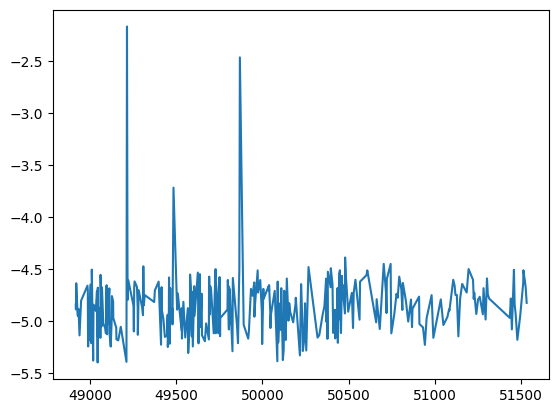

In [38]:
for x in raw_dataset.take(1):
    plt.plot(x['input'][0, ..., 0], x['input'][0, ..., 1])